### Устанавливаем необходимые библиотеки

In [1]:
# %pip install requests
# %pip install pandas
# %pip install numpy
# %pip install keras
# %pip install matplotlib


> 1. Изучить документацию RESTful API Binance (https://binance-docs.github.io/apidocs/spot/en/) и написать скрипт на Python с использованием библиотеки Requests, чтобы получить данные о котировках криптовалют. Сохранить полученные данные в формате CSV.

### Определяеv функцию fetch_data для загрузки данных о цене криптовалюты с помощью API Binance; сохраняем данные в CSV-файл

In [2]:
# импортирование необходимых библиотек
import os
import re
import math
import csv
import requests

url = 'https://api.binance.com/api/v3/klines'

headers = [
    'open_time', 'open', 'high', 'low', 'close', 'volume',
    'close_time', 'quote_asset_volume', 'number_of_trades',
    'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
]

# функция для разбора таймфрейма на составляющие
def parse_timeframe(timeframe):
    time = int(re.findall("[0-9]+", timeframe)[0])
    frame = str(re.findall("[a-zA-Z]+", timeframe)[0])
    if frame == 'm':
        divider = 60 * 1000
    elif frame == 'h':
        divider = 60 * 60 * 1000
    elif frame == 'd':    
        divider = 60 * 60 * 24 * 1000
    return time, divider

# функция для расчета дельты и итераций для определения промежутка времени в миллисекундах
def calculate_delta_and_iterations(start_time_ms, end_time_ms, timeframe):
    time, divider = parse_timeframe(timeframe)
    delta = int((end_time_ms - start_time_ms) / divider / time)
    limit = 1000
    rest = delta % limit
    iterations = [(limit, math.ceil(delta / limit))]
    if rest > 0:
        iterations.append((rest, 1))
    return iterations, time, divider

def fetch_data(symbol, timeframe, start_time_ms, end_time_ms, path='data/'):
    '''
    Функция обходит лимит в 1000 баров
    '''
    if not os.path.exists(path):
        os.makedirs(path)

    iterations, time, divider = calculate_delta_and_iterations(
        start_time_ms, end_time_ms, timeframe)

    whole_data = []
    timestamp = start_time_ms

    for (pack, iterations_count) in iterations:
        for _ in range(iterations_count):
            params = {
                'symbol': symbol,
                'interval': timeframe,
                'startTime': timestamp,
                'limit': pack
            }
            response = requests.get(url, params=params)
            whole_data.extend(response.json())

            timestamp += (divider * pack)

    with open(f'{path}/{symbol.lower()}_{timeframe}_data.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(headers)
        for row in whole_data:
            writer.writerow(row[:len(headers)])


### Устанавливаем параметры: временные рамки, время начала и окончания.

In [3]:
import datetime # модуль для работы с датой и временем

# Начальное и конечное время для получения данных
start_time = "2022-02-01 00:00:00"  # формат: "год-месяц-день час:минута:секунда"
end_time = "2023-03-01 00:00:00"  # формат: "год-месяц-день час:минута:секунда"

# Временной интервал и лимит для получения данных
timeframe = "1h"  # формат: "число + буква, например "1h" для получения данных за 1 час

# Начальное и конечное время в миллисекундах
start_time_ms = int(datetime.datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S").timestamp() * 1000)
end_time_ms = int(datetime.datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S").timestamp() * 1000)

# котировка и путь
symbol = 'ATOMUSDT'
path = 'data/'

fetch_data(symbol, timeframe, start_time_ms, end_time_ms)

> 2. Загрузить полученный CSV-файл с данными в Python с использованием библиотеки Pandas и выполнить предварительную обработку данных (например, удаление пропусков, преобразование даты и времени, масштабирование).

### Считываем данные в pandas DataFrame (df), извлекаем столбцы 'open_time' и 'close' и устанавливаем 'open_time' в качестве индекса после преобразования его в формат времени.

In [32]:
import pandas as pd

# загрузка данных из файла CSV в объект DataFrame
# путь к файлу и параметры symbol и timeframe определяются ранее
df = pd.read_csv(f'{path}/{symbol.lower()}_{timeframe}_data.csv')

df = df[['open_time', 'volume', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'number_of_trades', 'open', 'high', 'low', 'close']]

df["predicted_close"] = df["close"].shift(-4)

df

,open_time,volume,quote_asset_volume,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,number_of_trades,open,high,low,close,predicted_close
0,1643673600000,214335.57,6.092787e+06,116321.07,3.304303e+06,19064,28.060,28.900,27.780,28.760,29.550
1,1643677200000,107879.04,3.084020e+06,54476.89,1.558296e+06,8323,28.760,28.800,28.330,28.470,29.320
2,1643680800000,79379.07,2.268419e+06,42790.76,1.223571e+06,6176,28.470,28.760,28.270,28.550,29.140
3,1643684400000,301189.54,8.753288e+06,177787.67,5.172238e+06,21938,28.540,29.450,28.460,29.430,29.250
4,1643688000000,271282.94,8.034258e+06,141053.57,4.178622e+06,20874,29.430,29.840,29.380,29.550,29.550
...,...,...,...,...,...,...,...,...,...,...,...
10403,1681124400000,30883.00,3.401749e+05,16511.06,1.818893e+05,1320,11.033,11.045,10.996,11.007,11.034
10404,1681128000000,33096.68,3.637983e+05,13480.97,1.482007e+05,1372,11.007,11.013,10.971,10.987,NaN
10405,1681131600000,71713.43,7.866376e+05,25071.21,2.750338e+05,3201,10.986,11.016,10.935,10.944,NaN
10406,1681135200000,68063.10,7.455900e+05,22203.79,2.432394e+05,2949,10.942,10.982,10.925,10.967,NaN


In [5]:
# оставляем только столбцы 'open_time' и 'close'
df = df[['open_time', 'close']].copy()

# преобразуем столбец 'open_time' в объект datetime и устанавливаем его в качестве индекса
df['Date'] = pd.to_datetime(df['open_time'], unit='ms')
df.set_index('Date', inplace=True)

# удаляем столбец 'open_time'
df.drop('open_time', axis=1, inplace=True)

df


,close
Date,
2022-02-01 00:00:00,28.760
2022-02-01 01:00:00,28.470
2022-02-01 02:00:00,28.550
2022-02-01 03:00:00,29.430
2022-02-01 04:00:00,29.550
...,...
2023-04-10 11:00:00,11.007
2023-04-10 12:00:00,10.987
2023-04-10 13:00:00,10.944


<Axes: xlabel='Date'>

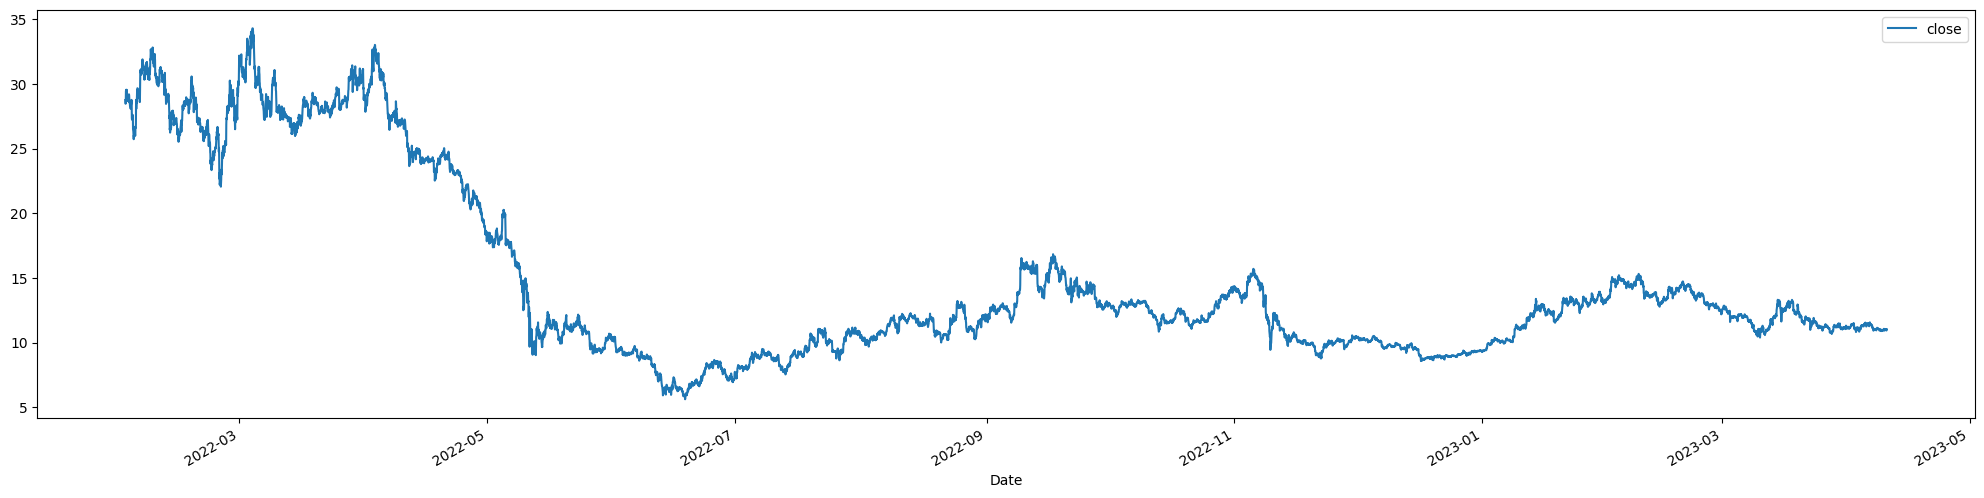

In [6]:
df.plot(figsize=(25,6))

> 3. С использованием библиотеки NumPy, разделить данные на обучающую и тестовую выборки.

### Подготавливаем новый DataFrame (windowed df), добавляя смещенные цены закрытия для создания окна с четырьмя лагами.

In [28]:
from sklearn.preprocessing import MinMaxScaler



# создаем копию DataFrame
windowed_df = df.copy()

# создаем объект MinMaxScaler для масштабирования данных
scaler = MinMaxScaler()

# масштабируем DataFrame и создаем новый DataFrame с масштабированными данными
scaled_df = scaler.fit_transform(windowed_df)
windowed_df = pd.DataFrame(scaled_df, columns=windowed_df.columns, index=windowed_df.index)

# добавляем новые столбцы 'target_a', 'target_b', 'target_c', 'target_d'
# значения цены закрытия сдвинуты на -1, -2, -3 и -4 строки соответственно
windowed_df.insert(0, 'target_a', windowed_df['close'].shift(-1))
windowed_df.insert(1, 'target_b', windowed_df['close'].shift(-2))
windowed_df.insert(2, 'target_c', windowed_df['close'].shift(-3))
windowed_df.insert(3, 'target_d', windowed_df['close'].shift(-4))

windowed_df

,target_a,target_b,target_c,target_d,close
Date,,,,,
2022-02-01 00:00:00,0.796652,0.799442,0.830136,0.834322,0.806767
2022-02-01 01:00:00,0.799442,0.830136,0.834322,0.826299,0.796652
2022-02-01 02:00:00,0.830136,0.834322,0.826299,0.820021,0.799442
2022-02-01 03:00:00,0.834322,0.826299,0.820021,0.823858,0.830136
2022-02-01 04:00:00,0.826299,0.820021,0.823858,0.834322,0.834322
...,...,...,...,...,...
2023-04-10 11:00:00,0.186850,0.185351,0.186153,0.188490,0.187548
2023-04-10 12:00:00,0.185351,0.186153,0.188490,NaN,0.186850
2023-04-10 13:00:00,0.186153,0.188490,NaN,NaN,0.185351


### Нормализует DataFrame с помощью MinMaxScaler.

In [8]:
import numpy as np


# сбрасываем индекс DataFrame и устанавливаем 'target_date' в качетсве индекса
windowed_df.reset_index(inplace=True, names='target_date')

# оставляем только последние n строк DataFrame
n = 1000
windowed_df = windowed_df[-n:]

# функция для преобразования DataFrame в кортеж из дат, признаков и целевых значений
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

# применяем функцию windowed_df_to_date_X_y к объекту DataFrame и сохраняем результат в переменные dates, X и y
dates, X, y = windowed_df_to_date_X_y(windowed_df)

# выводим размерности массивов dates, X и y
dates.shape, X.shape, y.shape


((1000,), (1000, 4, 1), (1000,))

### Разделение данных на обучающий, проверочный и тестовый наборы на основе соотношения 80-10-10.

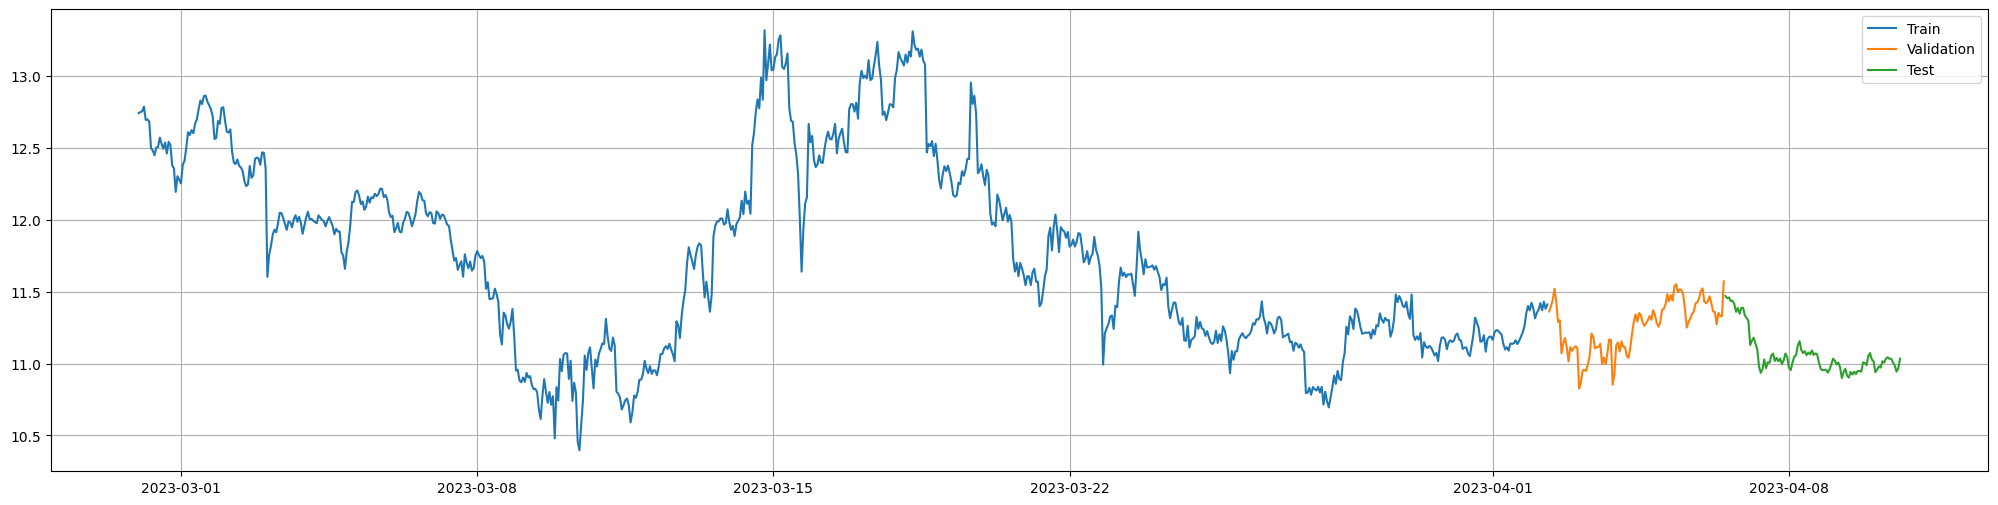

In [9]:
# Импорт библиотеки для построения графиков
import matplotlib.pyplot as plt

# Вычисление индексов для разбиения данных на тренировочную, валидационную и тестовую выборки
q_80 = int(len(dates) * .8) # 80% данных для тренировки
q_90 = int(len(dates) * .9) # 10% данных для валидации и 10% для тестирования

# Разбиение данных на тренировочную выборку
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

# Разбиение данных на валидационную выборку
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]

# Разбиение данных на тестовую выборку
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

# Настройка размера графика
plt.figure(figsize=(25,6))
plt.grid()
# Построение графиков для тренировочной, валидационной и тестовой выборок
plt.plot(dates_train, scaler.inverse_transform(y_train.reshape(-1, 1)))
plt.plot(dates_val, scaler.inverse_transform(y_val.reshape(-1, 1)))
plt.plot(dates_test, scaler.inverse_transform(y_test.reshape(-1, 1)))

# Добавление легенды к графику
plt.legend(['Train', 'Validation', 'Test'])


> 4. Создать и обучить LSTM-модель с использованием библиотеки Keras или TensorFlow на основе подготовленных данных. Подобрать архитектуру и гиперпараметры модели, чтобы достичь наилучшего качества прогнозирования.

> 5. Оценить качество модели на тестовой выборке, используя подходящие метрики, такие как среднеквадратичная ошибка (MSE) или средняя абсолютная ошибка (MAE).


### Загружаем необходимые библиотеки и подготавливаем модель

In [10]:
# Импорт необходимых модулей из библиотеки TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Создание последовательной модели
model = Sequential([layers.Input((4, 1)), # Входной слой с размерностью входных данных (4, 1)
                    layers.LSTM(64), # Скрытый слой LSTM с 64 нейронами
                    layers.Dense(32, activation='relu'), # Полносвязный слой с 32 нейронами и функцией активации ReLU
                    layers.Dense(32, activation='relu'), # Полносвязный слой с 32 нейронами и функцией активации ReLU
                    layers.Dense(1)]) # Выходной слой с одним нейроном

# Компиляция модели
model.compile(loss='mse', # Функция потерь - среднеквадратичная ошибка
              optimizer=Adam(learning_rate=0.001), # Оптимизатор Adam с заданным коэффициентом обучения
              metrics=['mean_absolute_error']) # Метрика качества модели - средняя абсолютная ошибка

# Обучение модели на тренировочных данных
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)


2023-04-10 15:47:28.308478: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 15:47:28.351295: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 15:47:28.352366: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 15:47:29.577729: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/100


2023-04-10 15:47:30.668490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-10 15:47:30.670544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-10 15:47:30.671915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

18/25 [====================>.........] - ETA: 0s - loss: 0.0297 - mean_absolute_error: 0.1674 

2023-04-10 15:47:32.840307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-10 15:47:32.842350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-10 15:47:32.843737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 2s 23ms/step - loss: 0.0228 - mean_absolute_error: 0.1386 - val_loss: 9.7581e-05 - val_mean_absolute_error: 0.0087
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 9.3106e-04 - mean_absolute_error: 0.0251 - val_loss: 3.0446e-05 - val_mean_absolute_error: 0.0046
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 3.8228e-04 - mean_absolute_error: 0.0160 - val_loss: 3.2429e-04 - val_mean_absolute_error: 0.0173
Epoch 4/100
25/25 [==============================] - 0s 7ms/step - loss: 3.0426e-04 - mean_absolute_error: 0.0147 - val_loss: 2.2389e-04 - val_mean_absolute_error: 0.0141
Epoch 5/100
25/25 [==============================] - 0s 4ms/step - loss: 2.9457e-04 - mean_absolute_error: 0.0145 - val_loss: 1.2943e-04 - val_mean_absolute_error: 0.0102
Epoch 6/100
25/25 [==============================] - 0s 4ms/step - loss: 2.8883e-04 - mean_absolute_error: 0.0143 - val_loss: 1.7954e-04 - val_mean_absolute_err

> 6. Визуализировать предсказания модели для тестовой выборки на графике с помощью библиотеки Matplotlib или Plotly. Вывести график с предсказанием на час вперед от последних полученных данных.


25/25 [==============================] - 0s 2ms/step


2023-04-10 15:47:53.215618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-10 15:47:53.217745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-10 15:47:53.219107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

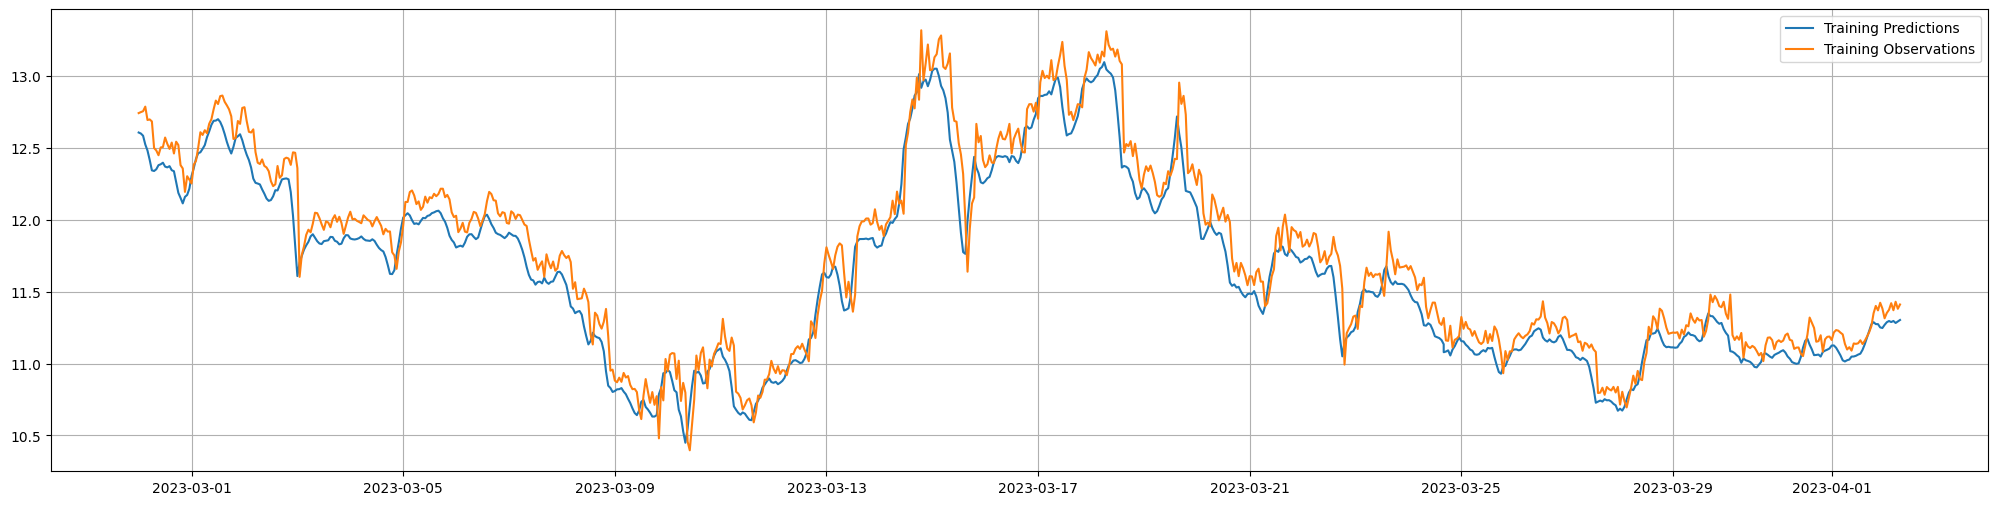

In [11]:
# Получение предсказаний модели на тренировочных данных
train_predictions = model.predict(X_train).flatten()

# Визуализация предсказаний модели и фактических значений на тренировочных данных
plt.figure(figsize=(25,6))
plt.grid()
plt.plot(dates_train, scaler.inverse_transform(train_predictions.reshape(-1, 1))) # График предсказаний
plt.plot(dates_train, scaler.inverse_transform(y_train.reshape(-1, 1))) # График фактических значений
plt.legend(['Training Predictions', 'Training Observations']) # Наименование графиков в легенде


4/4 [==============================] - 0s 3ms/step


2023-04-10 15:47:54.627974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-10 15:47:54.630009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-10 15:47:54.631426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

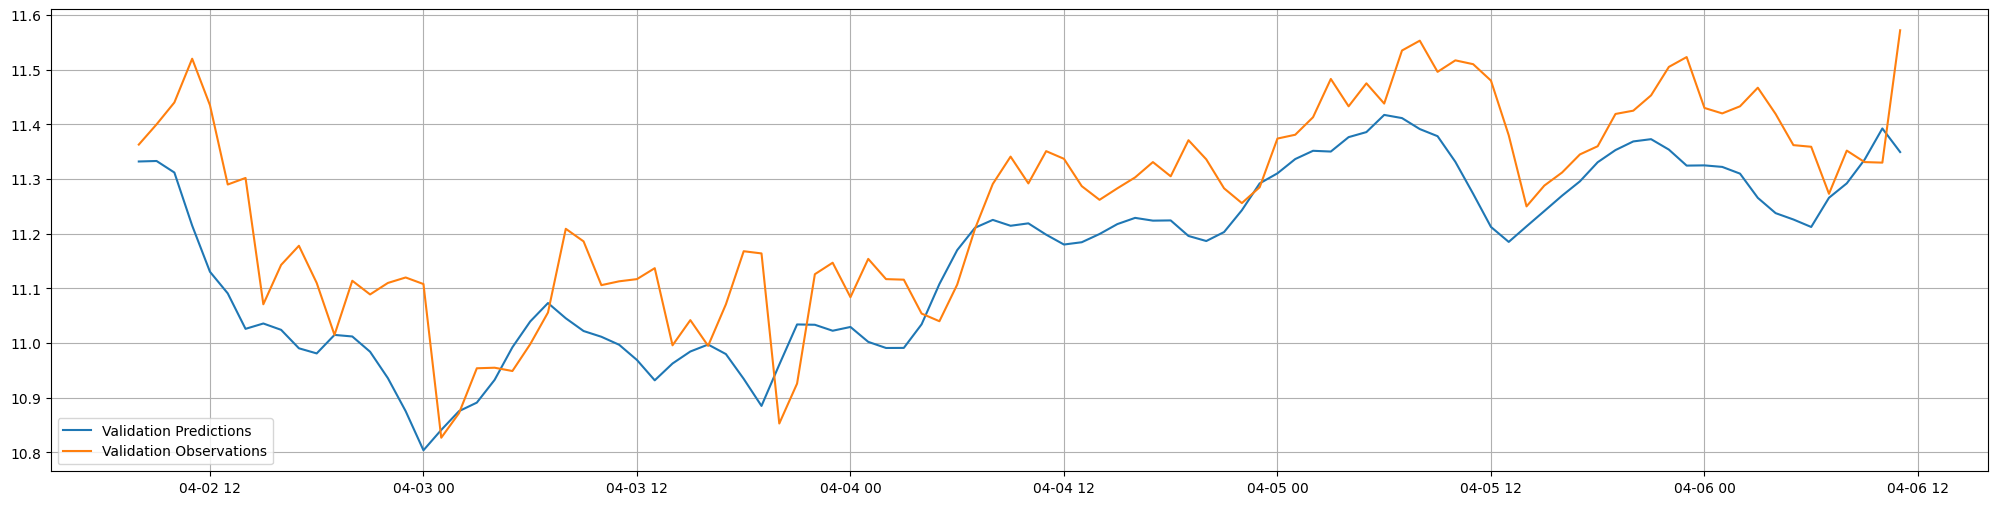

In [12]:
# Получение предсказаний модели на вадидационных данных
val_predictions = model.predict(X_val).flatten()

# Визуализация предсказаний модели и фактических значений
plt.figure(figsize=(25,6))
plt.grid()
plt.plot(dates_val, scaler.inverse_transform(val_predictions.reshape(-1, 1)))
plt.plot(dates_val, scaler.inverse_transform(y_val.reshape(-1, 1)))
plt.legend(['Validation Predictions', 'Validation Observations'])

4/4 [==============================] - 0s 3ms/step


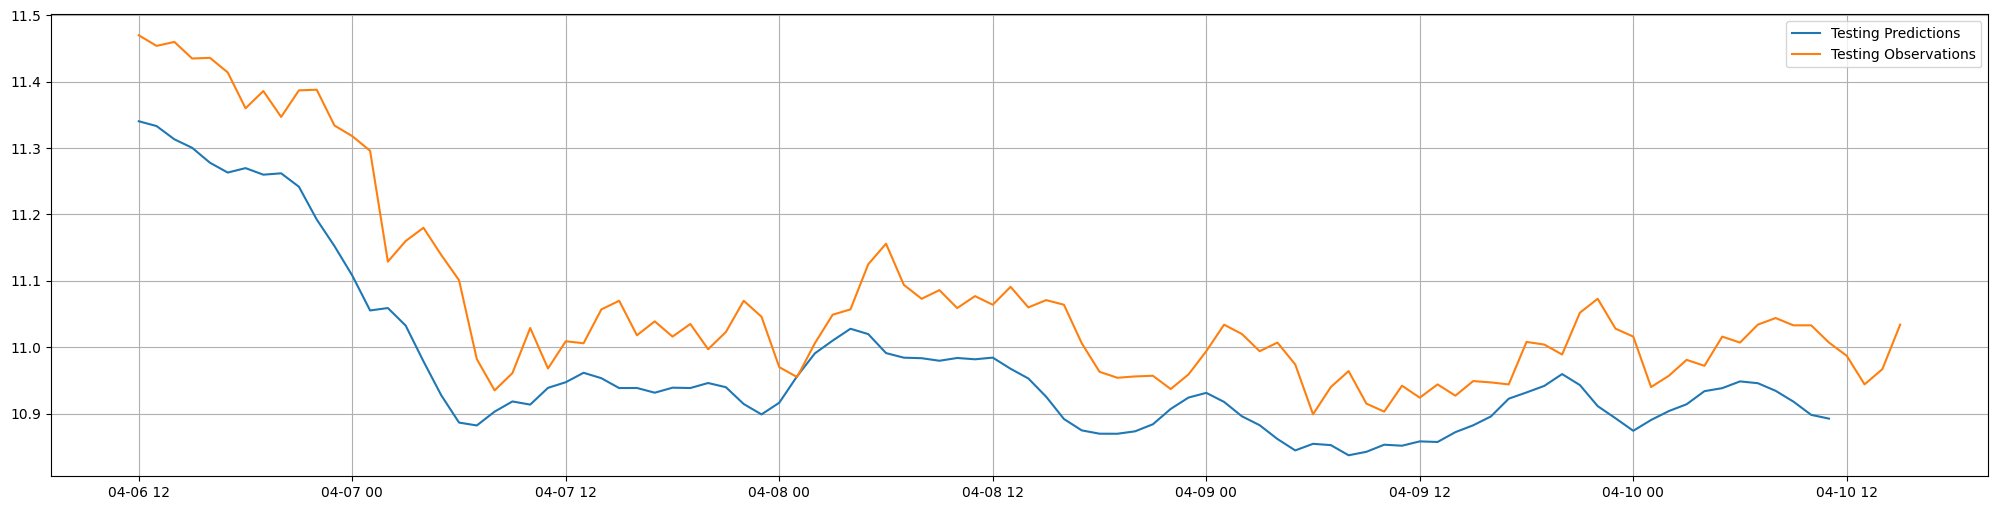

In [13]:
# Получение предсказаний модели на тестовых данных
test_predictions = model.predict(X_test).flatten()

# scaler.inverse_transform(test_predictions.reshape(-1, 5))

# Визуализация предсказаний модели и фактических значений на тестовых данных
plt.figure(figsize=(25,6))
plt.grid()
plt.plot(dates_test, scaler.inverse_transform(test_predictions.reshape(-1, 1))) # График предсказаний
plt.plot(dates_test, scaler.inverse_transform(y_test.reshape(-1, 1))) # График фактических значений
plt.legend(['Testing Predictions', 'Testing Observations']) # Наименование графиков в легенде

In [27]:
pd.DataFrame(X_test.reshape((100, 4)))

,0,1,2,3
0,0.203139,0.203348,0.202476,0.202511
1,0.203348,0.202476,0.202511,0.201744
2,0.202476,0.202511,0.201744,0.199860
3,0.202511,0.201744,0.199860,0.200767
4,0.201744,0.199860,0.200767,0.199407
...,...,...,...,...
95,0.186850,0.185351,0.186153,0.188490
96,0.185351,0.186153,0.188490,NaN
97,0.186153,0.188490,NaN,NaN
98,0.188490,NaN,NaN,NaN


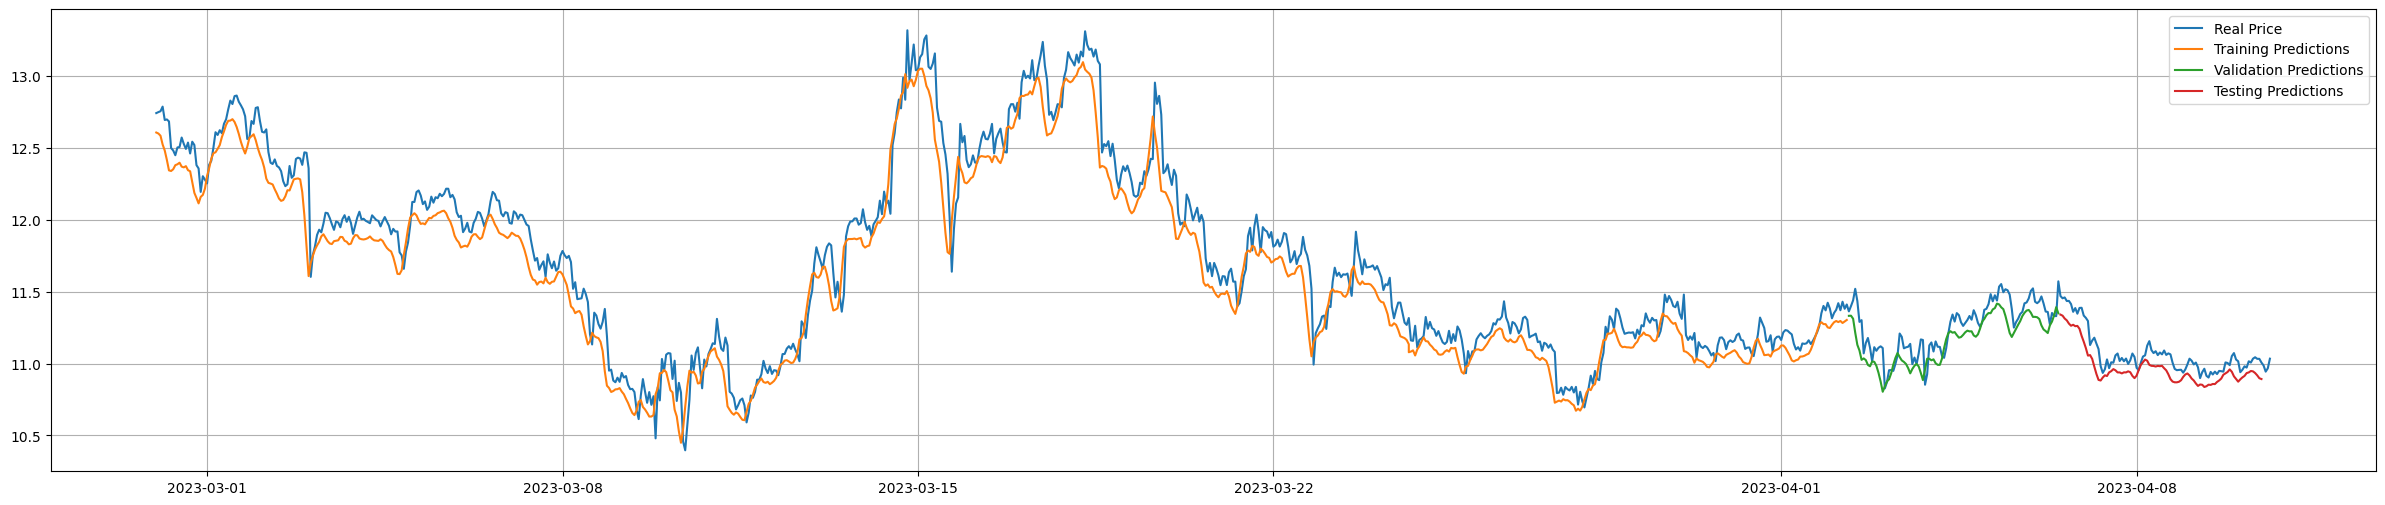

In [25]:
plt.figure(figsize=(30,6))
plt.grid()
plt.plot(df.index[-n:], df[-n:]) 
plt.plot(dates_train, scaler.inverse_transform(train_predictions.reshape(-1, 1)))
#plt.plot(dates_train, scaler.inverse_transform(y_train.reshape(-1, 1)))
plt.plot(dates_val, scaler.inverse_transform(val_predictions.reshape(-1, 1)))
#plt.plot(dates_val, scaler.inverse_transform(y_val.reshape(-1, 1)))
plt.plot(dates_test, scaler.inverse_transform(test_predictions.reshape(-1, 1)))
#plt.plot(dates_test, scaler.inverse_transform(y_test.reshape(-1, 1)))


plt.legend(['Real Price',
            'Training Predictions', 
            #'Training Observations',
            'Validation Predictions', 
            #'Validation Observations',
            'Testing Predictions', 
            #'Testing Observations',
            ])
